# Getting started with Bifrost

These tutorials require an installation of Bifrost and a machine with a GPU. The simplest way to start is using Google Colab. There are tips for other ways to run them in [the README](https://github.com/ledatelescope/bifrost/blob/master/tutorial/README.md).

<a href="https://colab.research.google.com/github/ledatelescope/bifrost/blob/master/tutorial/00_getting_started.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"></a>

Once Bifrost is installed you can load the Python API with
```python
import bifrost
```

In [8]:
%%capture install_log
# Import bifrost, but attempt to auto-install if needed (and we're running on
# Colab). If something goes wrong, evaluate install_log.show() in a new block
# to retrieve the details.
try:
  import bifrost
except ModuleNotFoundError:
  try:
    import google.colab
    !sudo apt-get -qq install exuberant-ctags libopenblas-dev software-properties-common build-essential
    !pip install -q contextlib2 pint simplejson scipy git+https://github.com/ctypesgen/ctypesgen.git
    ![ -d ~/bifrost/.git ] || git clone https://github.com/ledatelescope/bifrost ~/bifrost
    !(cd ~/bifrost && ./configure && make -j all && sudo make install)
    import bifrost
  except ModuleNotFoundError:
    print("Sorry, could not import bifrost and we're not on colab.")

This loads the core parts of Bifrost and several useful functions.  The main way of interacting with Bifrost is through the `bifrost.ndarray`, a sub-class of `numpy.ndarray`.  You can create an empty array with:

In [4]:
data = bifrost.ndarray(shape=(2,4096), dtype='f32', space='system')
print(type(data), data.dtype, data.shape, data.bf.space)
print(data)

<class 'bifrost.ndarray.ndarray'> float32 (2, 4096) system
[[ 2.2875120e-35  0.0000000e+00  1.5581004e-38 ...  1.3563156e-19
   2.8297670e+20  2.6373977e+23]
 [ 2.0704474e-19  7.1220526e+28  1.4251251e-13 ...  2.7550649e-40
   6.1529782e-39 -5.7935773e-05]]


Note that bifrost defines datatypes differently to numpy:
```
f32: 32-bit float (equivalent to numpy float32)
cf32: complex 32-bit data (equivalent to numpy complex64)
i[8,16,32]: signed integer datatypes of 8, 16 and 32-bit width
u[8,16,32]: unsigned integer datatypes of 8, 16 and 32-bit width
ci[4,8,16,32]: complex 4-bit per sample, 8-bit, 16-bit and 32-bit datatypes
```

The `ci4`, `ci8` and `ci16` datatypes do not have an equivalent numpy type, but are commonly encountered in radio astronomy.

You can also use the `bifrost.ndarray` to wrap existing numpy arrays:

In [5]:
import numpy
r = numpy.random.randn(2, 4096)
data = bifrost.ndarray(r)
print(type(data), data.dtype, data.shape, data.bf.space)
print('r:', r)
print('data:', data)

<class 'bifrost.ndarray.ndarray'> float64 (2, 4096) system
r: [[-0.3415904   0.07395837  1.1215293  ...  0.52340138 -0.43369748
   0.99678685]
 [-0.74268647  1.9056947  -0.23712155 ...  0.65987519  1.13804761
   0.36587976]]
data: [[-0.3415904   0.07395837  1.1215293  ...  0.52340138 -0.43369748
   0.99678685]
 [-0.74268647  1.9056947  -0.23712155 ...  0.65987519  1.13804761
   0.36587976]]


Since `bifrost.ndarray`s are derived from numpy arrays they can do many (but not all) of the same things:

In [6]:
data += 2.0
print('data += 2.0:', data)
data[0,:] = 55
print('data[0,:] = 55:', data)

data += 2.0: [[1.6584096  2.07395837 3.1215293  ... 2.52340138 1.56630252 2.99678685]
 [1.25731353 3.9056947  1.76287845 ... 2.65987519 3.13804761 2.36587976]]
data[0,:] = 55: [[55.         55.         55.         ... 55.         55.
  55.        ]
 [ 1.25731353  3.9056947   1.76287845 ...  2.65987519  3.13804761
   2.36587976]]


In [7]:
data[:,[1,3,5,7]] = 10
print('data[:,[1,3,5,7]] = 10:', data)

data[:,[1,3,5,7]] = 10: [[55.         55.         55.         ... 55.         55.
  55.        ]
 [ 1.25731353  3.9056947   1.76287845 ...  2.65987519  3.13804761
   2.36587976]]


You can also use `bifrost.ndarray`s with [numba](https://numba.pydata.org/):

In [8]:
from numba import jit

@jit(nopython=True)
def compute(x):
    for i in range(len(x)):
        x[i] = x[i] + 10

compute(data)
print(type(data), data)

<class 'bifrost.ndarray.ndarray'> [[65.         65.         65.         ... 65.         65.
  65.        ]
 [11.25731353 13.9056947  11.76287845 ... 12.65987519 13.13804761
  12.36587976]]


### Arrays on the CPU and GPU

Unlike numpy arrays `bifrost.ndarray` are "space aware", meaning that they can exist in different memory spaces.  What we have created so far is in system memory.  `bifrost.ndarray`s can also exist in "cuda_host" (pinned) memory and "cuda" (GPU) memory:

In [9]:
data2 = bifrost.ndarray(shape=(2,4096), dtype='f32', space='cuda_host')
data3 = bifrost.ndarray(shape=(2,4096), dtype='f32', space='cuda')
print(type(data2), data2.dtype, data2.shape, data2.bf.space)
print(type(data3), data3.dtype, data3.shape, data3.bf.space)

<class 'bifrost.ndarray.ndarray'> float32 (2, 4096) cuda_host
<class 'bifrost.ndarray.ndarray'> float32 (2, 4096) cuda


To move between the different spaces the `bifrost.ndarray` class provides a `copy` method:

In [10]:
data4 = data.copy(space='cuda')
print(type(data4), data4.dtype, data4.shape, data4.bf.space)

<class 'bifrost.ndarray.ndarray'> float64 (2, 4096) cuda


Once on the GPU you can take advantage of Bifrost's GPU-based functions, like `bifrost.map`:

In [11]:
bifrost.map("a(i,j) *= 10",
            {'a': data4},
            axis_names=('i', 'j'),
            shape=data4.shape)
data4 = data4.copy(space='system')
print('data4/data = data*10/data = 10:', data4/data)

data4/data = data*10/data = 10: [[10. 10. 10. ... 10. 10. 10.]
 [10. 10. 10. ... 10. 10. 10.]]


The `bifrost.map` call here compiles and runs a CUDA kernel that does an element-wise multiplication by ten.  In order to view the results of this kernel call we need to copy the memory back to the "system" memory space.  In the future we hope to support a "cuda_managed" space to make this easier.

`bifrost.map` is an example of a function that does not require any additional setup to run. This code is converted into a CUDA kernel at runtime, using [NVRTC](https://docs.nvidia.com/cuda/nvrtc/index.html). 

For some Bifrost functions, like `bifrost.fft.Fft`, some setup is required so that the function knows how to run. To show the use of the Bifrost FFT, let us first make some example data on the GPU, using `bf.map`:

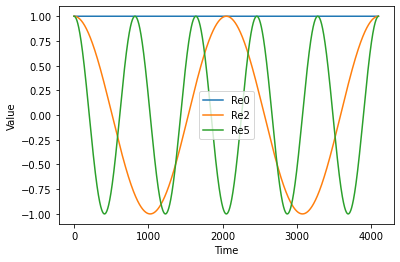

In [12]:
data = bifrost.ndarray(shape=(16, 4096), dtype='cf32', space='cuda')
bifrost.map("a(i,j) = exp(Complex<float>(0.0, 2*3.14*i*j/4096))",
            {'a': data},
            axis_names=('i', 'j'),
            shape=data.shape)
data2 = data.copy(space='system')

import pylab
pylab.plot(data2[0,:].real, label='Re0')
#pylab.plot(data2[0,:].imag, label='Im0')
pylab.plot(data2[2,:].real, label='Re2')
#pylab.plot(data2[2,:].imag, label='Im2')
pylab.plot(data2[5,:].real, label='Re5')
#pylab.plot(data2[5,:].imag, label='Im5')
pylab.xlabel('Time')
pylab.ylabel('Value')
pylab.legend(loc=0)

Now run the FFT and plot the results. The FFT is initialised using its `.init` method, and then executed using its `.execute` method.  An output data array also needs to be pre-allocated :

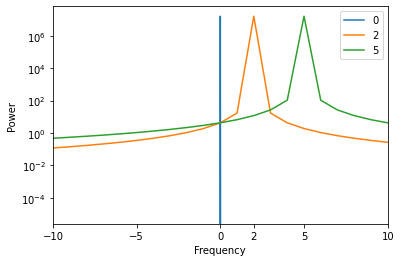

In [13]:
fdata = bifrost.ndarray(shape=data.shape, dtype='cf32', space='cuda')
f = bifrost.fft.Fft()
f.init(data, fdata, axes=1, apply_fftshift=True)
f.execute(data, fdata)
fdata2 = fdata.copy(space='system')
ffreqs = numpy.fft.fftfreq(fdata2.shape[1], d=1/4096.)
ffreqs = numpy.fft.fftshift(ffreqs)

pylab.semilogy(ffreqs, numpy.abs(fdata2[0,:])**2, label='0')
pylab.semilogy(ffreqs, numpy.abs(fdata2[2,:])**2, label='2')
pylab.semilogy(ffreqs, numpy.abs(fdata2[5,:])**2, label='5')
pylab.xlabel('Frequency')
pylab.ylabel('Power')
pylab.xlim(-10, 10)
pylab.xticks([-10,-5,0,2,5,10])
pylab.legend(loc=0)